<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
## **Capstone Project: Ride BigApple** 🚖🍎

---
**Pre Processing and Modeling**

In [586]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

In [588]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [590]:
# maps module
#import googlemaps

# import geodesic module
# from geopy.distance import geodesic

In [869]:
# read in file
file_path = '../data/clean_data/taxi_clean_set_v2.csv'

taxi = pd.read_csv(file_path, index_col = 'key')
print(taxi.shape)

(53351, 12)


In [871]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance'],
      dtype='object')

----
**Baseline Model**

In [874]:
# x matrix
X1 = taxi[['geodesic_distance']]

# y target
y1 = taxi['fare_amount']

# check dimensions
X1.shape, y1.shape

((53351, 1), (53351,))

In [1328]:
# train/test split, default of 75/25

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state = 1976)

In [1330]:
# check dimensions
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((40013, 1), (13338, 1), (40013,), (13338,))

In [1332]:
# instantiate linear model
lr1 = LinearRegression()

In [1334]:
# fit linear model
lr1.fit(X_train1, y_train1)

LinearRegression()

In [1336]:
round(lr1.score(X_train1, y_train1), 3)

0.812

In [1338]:
round(lr1.score(X_test1, y_test1), 3)

0.822

In [1340]:
y_preds1 = lr1.predict(X_test1)
y_preds1

array([17.23535219, 13.58803121,  9.1944752 , ...,  8.94292313,
       16.61563814,  7.02778828])

In [1342]:
round(root_mean_squared_error(y_test1, y_preds1), 2)

3.89

---
**Clustering**

In [893]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [894]:
# P matrix, for pickup coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

P = np.radians(taxi[['pickup_longitude', 'pickup_latitude']].values)
P.shape

(53351, 2)

**Epsilon**<br>
With about 90% of pickups ocurring in Manhattan, let's focus on finding a value for epsilon that is based on the Manhattan grid.<br><br>
Avenues run north-south and viceversa (6th Avenue, 7th Avenue, Broadway, etc.). And streets run east-west/viceversa (57th Street, 34th Street, Houston Street, etc.).  So, we'll call a city block a block from one street to the next, either north or south.  Based on <a href = 'https://gottalovenewyork.com/what-is-the-size-of-manhattan/'>research</a>, the approximate length of a standard city block is about 80 meters, which in degrees (since we're using longitude/latitude data) is approximately 0.00072.<br><br>
A good distance to cluster rides around would range from 1 city block to 5 city blocks.  In meters that would range from 80 meters to 400 meters.  And for the values of epsilon, that would range from  0.00072 degrees to 0.00360 degress.<br><br>
Since this is geographical/spatial data, the metric  for `DBSCAN` must be **Haversine** in order to take into account longitude and latitude coordinates as well as the earth's curvature.

In [898]:
# values of epsilon to try
epsilons = np.linspace(0.00072, 0.00360, 5)

# conversion factor to turn epsilon into radians
radians_conversion = (np.pi / 180)

# mininum number of rides to cluster
minimum_rides = [30, 45, 60]

In [627]:
%%time
# this will be time consuming, let's measure it to have an idea for future iterations

results1 = []

# determine best combination
for eps in epsilons:
    for rides in minimum_rides:
        dbs = DBSCAN(
        # using Haversine distance, so it must be converted to radians
        eps = eps * radians_conversion,         
        # only consider clusters based on certain number of pickups within the search radius                 
        min_samples = rides,
        # use Haversine distance, which measures actual distance over earth's surface
        metric = 'haversine',
        n_jobs = -1)

        dbs.fit(P)
        labels = dbs.labels_

        clusters = len(np.unique(labels[labels != -1]))
    
        silhouette = silhouette_score(P, labels, metric='haversine') if clusters > 1 else -1
        
        results1.append(
            {'epsilon': eps, 
             'min_samples': rides, 
             'clusters': clusters, 
             'silhouette_score': silhouette}
        )
    print(f'Epsilon {eps} done.')

Epsilon 0.00072 done.
Epsilon 0.0014399999999999999 done.
Epsilon 0.00216 done.
Epsilon 0.0028799999999999997 done.
Epsilon 0.0036 done.
CPU times: total: 47min 31s
Wall time: 46min 26s


In [670]:
summary_table = pd.DataFrame(results1)
summary_table

,epsilon,min_samples,clusters,silhouette_score
0,0.00072,30,16,-0.470738
1,0.00072,45,17,-0.431408
2,0.00072,60,21,-0.493909
3,0.00144,30,11,-0.038394
4,0.00144,45,11,-0.082117
5,0.00144,60,7,0.251721
6,0.00216,30,10,0.088988
7,0.00216,45,8,-0.045404
8,0.00216,60,5,-0.024897
9,0.00288,30,9,0.256899


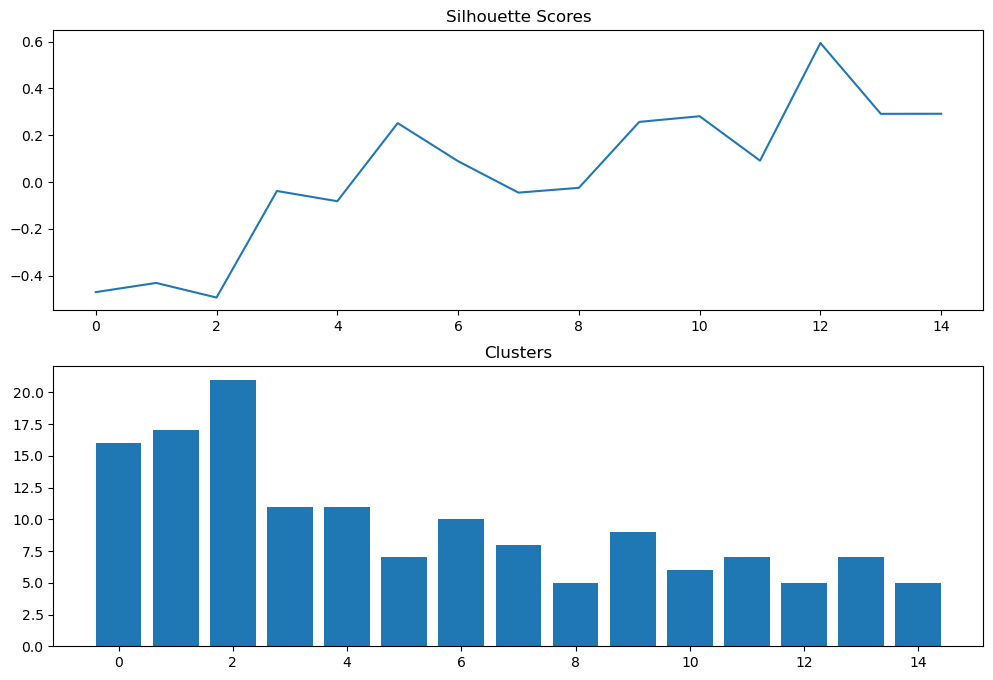

In [631]:
# plot silhouette scores and clusters
plt.figure(figsize = (12, 8))
plot1 = plt.subplot(2, 1, 1)
plot2 = plt.subplot(2, 1, 2)

plot1.plot(summary_table['silhouette_score'])
plot1.set_title('Silhouette Scores')

plot2.bar(x = range(15), height = summary_table['clusters'])
plot2.set_title('Clusters')

plt.savefig('../images/silhouette_scores_clusters.png');

In [44]:
# replicate DBS with eps=0.00360 (5 blocks), mininum rides = 30
dbs1 = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 30, 
             metric = 'haversine')

In [46]:
# fit model
dbs1.fit(P)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=30)

In [48]:
# confirm silhouette score
round(silhouette_score(P, dbs1.labels_, metric = 'haversine'), 3)

0.594

In [900]:
# add pickup clusters column
taxi['pickup_clusters'] = dbs1.labels_

In [902]:
# check counts
taxi['pickup_clusters'].value_counts()

pickup_clusters
 0    50752
 1      912
 3      774
-1      440
 2      414
 4       59
Name: count, dtype: int64

In [1912]:
color_map = {
 -1: '#c7c7c7',    # outliers

  0: '#ac2020',    # pickups: manhattan, downtown brooklyn, willliamsburg
                   # dropoffs: manhattan, and brooklyn/queens areas close to manhattan
 
  1: '#052f5f',    # pickups: lga airport
                   # dropoffs: lga airport and vicinity
   
  2: '#f77f00',    # pickups: long island city and surrounding area
                   # dropoffs: jfk airport
 
  3: '#17b890',    # pickups: jfk airport
                   # dropoffs: ewr airport
 
  4: '#007fff',    # pickups: just outside lga
                   # dropoffs: brooklyn, east of prospect park

  5: '#7b00ff'     # pickups: NA
                   # dropoffs: Woodside/Jackson Heights
}

In [906]:
taxi['pickup_clusters_color'] = taxi['pickup_clusters'].map(color_map)

In [1346]:
taxi['pickup_clusters_color'].value_counts()

pickup_clusters_color
#ac2020    50752
#052f5f      912
#17b890      774
#c7c7c7      440
#f77f00      414
#007fff       59
Name: count, dtype: int64

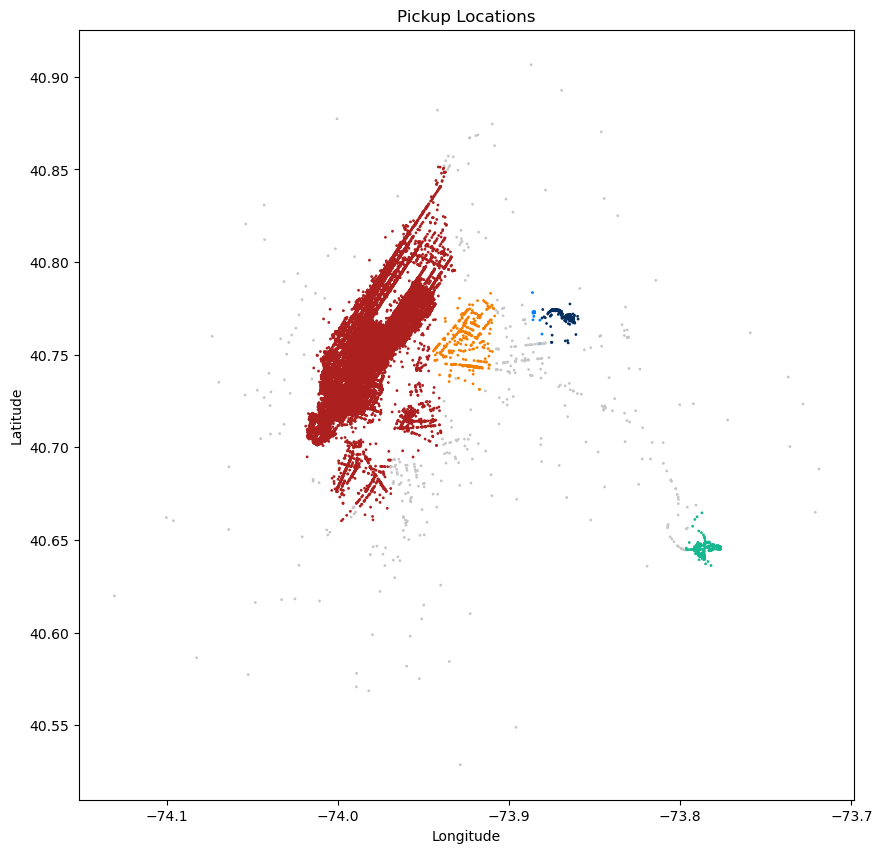

In [910]:
plt.figure(figsize = (10, 10))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Pickup Locations')
plt.scatter(taxi['pickup_longitude'],
            taxi['pickup_latitude'], 
            c = taxi['pickup_clusters_color'], 
            s = 1);

#plt.savefig('../images/scatter_pickup_cluster_locations.png');

In [912]:
dummy_col_pickups = pd.get_dummies(taxi['pickup_clusters'], prefix = 'p', prefix_sep = '_', drop_first = True, dtype = int)

In [914]:
dummy_col_pickups.shape

(53351, 5)

In [916]:
print(f'Before: {taxi.shape}')
taxi = pd.concat([taxi, dummy_col_pickups], axis = 1)
print(f'After: {taxi.shape}')

Before: (53351, 14)
After: (53351, 19)


In [918]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4'],
      dtype='object')

---
**Updated Linear Model**

In [920]:
cols_to_drop = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'pickup_clusters', 'pickup_clusters_color']

In [922]:
X2 = taxi.drop(columns = cols_to_drop)
y2 = taxi['fare_amount']

X2.shape, y2.shape

((53351, 6), (53351,))

In [924]:
X2.columns

Index(['geodesic_distance', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4'], dtype='object')

In [1348]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 1976, stratify = taxi['pickup_clusters'])

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((40013, 6), (13338, 6), (40013,), (13338,))

In [1350]:
lr2 = LinearRegression()

In [1352]:
lr2.fit(X_train2, y_train2)

LinearRegression()

In [1354]:
round(lr2.score(X_train2, y_train2), 3)

0.819

In [1356]:
round(lr2.score(X_test2, y_test2), 3)

0.823

In [1358]:
y_preds2 = lr2.predict(X_test2)
y_preds2

array([10.97171062, 12.95576842, 26.5778768 , ...,  6.07848507,
        8.70659522,  9.93018627])

In [1360]:
round(root_mean_squared_error(y_test2, y_preds2), 3)

3.836

------
**Dropoffs**

In [941]:
# D matrix, for dropoff coordinates
# convert coordinates to radians, this is to use geodesic distances
# which are actual distances on earth's surface
# then the metric becomes Haversine distance

D = np.radians(taxi[['dropoff_longitude', 'dropoff_latitude']].values)
D.shape

(53351, 2)

In [633]:
%%time
# this will be time consuming, let's measure it to have an idea for future iterations

results2 = []

# determine best combination
for eps in epsilons:
    for rides in minimum_rides:
        dbs = DBSCAN(
        # using Haversine distance, so it must be converted to radians
        eps = eps * radians_conversion,         
        # only consider clusters based on certain number of pickups within the search radius                 
        min_samples = rides,
        # use Haversine distance, which measures actual distance over earth's surface
        metric = 'haversine',
        n_jobs = -1)

        dbs.fit(D)
        labels = dbs.labels_

        clusters = len(np.unique(labels[labels != -1]))
    
        silhouette = silhouette_score(D, labels, metric='haversine') if clusters > 1 else -1
        
        results2.append(
            {'epsilon': eps, 
             'min_samples': rides, 
             'clusters': clusters, 
             'silhouette_score': silhouette}
        )
    print(f'Epsilon {eps} done.')

Epsilon 0.00072 done.
Epsilon 0.0014399999999999999 done.
Epsilon 0.00216 done.
Epsilon 0.0028799999999999997 done.
Epsilon 0.0036 done.
CPU times: total: 46min 43s
Wall time: 45min 50s


In [713]:
summary_table2 = pd.DataFrame(results2)
summary_table2

,epsilon,min_samples,clusters,silhouette_score
0,0.00072,30,14,-0.445016
1,0.00072,45,9,0.054387
2,0.00072,60,16,-0.468283
3,0.00144,30,22,-0.252421
4,0.00144,45,14,-0.162982
5,0.00144,60,8,-0.141667
6,0.00216,30,11,0.206948
7,0.00216,45,13,0.018075
8,0.00216,60,9,0.014328
9,0.00288,30,7,0.639085


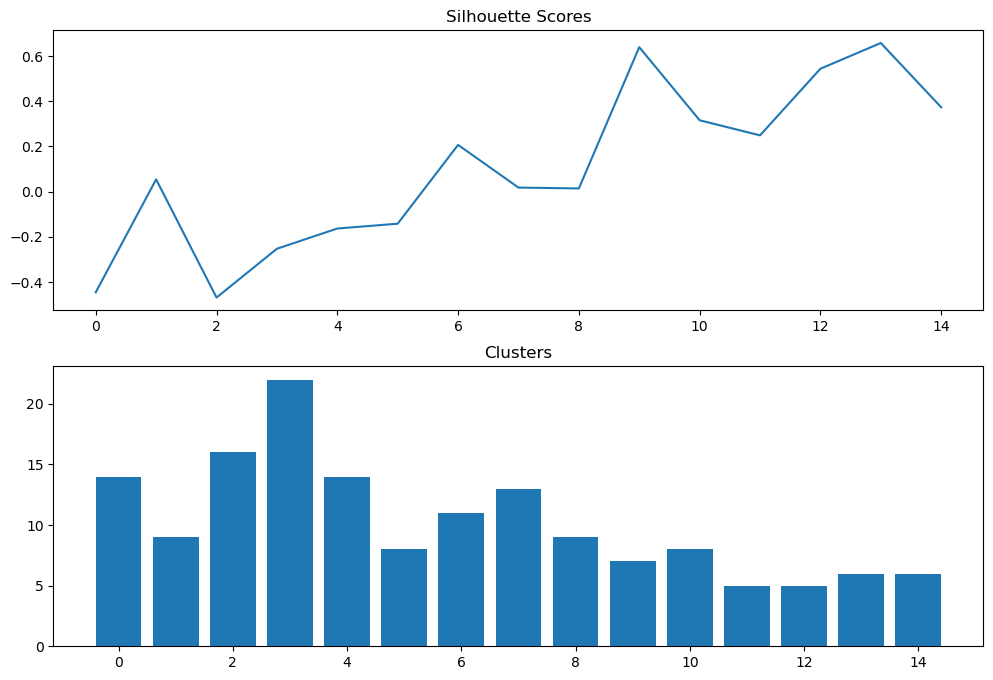

In [637]:
# plot silhouette scores and clusters
plt.figure(figsize = (12, 8))
plot1 = plt.subplot(2, 1, 1)
plot2 = plt.subplot(2, 1, 2)

plot1.plot(summary_table2['silhouette_score'])
plot1.set_title('Silhouette Scores')

plot2.bar(x = range(15), height = summary_table2['clusters'])
plot2.set_title('Clusters');

#plt.savefig('../images/silhouette_scores_clusters.png');

In [639]:
# replicate DBS with eps=0.00360 (5 blocks), mininum rides = 45
dbs2 = DBSCAN(eps = 0.00360 * radians_conversion, 
             min_samples = 45, 
             metric = 'haversine')

In [641]:
dbs2.fit(D)

DBSCAN(eps=6.283185307179586e-05, metric='haversine', min_samples=45)

In [643]:
round(silhouette_score(D, dbs2.labels_, metric = 'haversine'), 3)

0.658

In [944]:
# add dropoff clusters column
taxi['dropoff_clusters'] = dbs2.labels_

In [1364]:
taxi['dropoff_clusters'].value_counts()

dropoff_clusters
 0    50631
-1     1456
 1      684
 2      346
 4      125
 3       62
 5       47
Name: count, dtype: int64

In [948]:
taxi['dropoff_clusters_color'] = taxi['dropoff_clusters'].map(color_map)

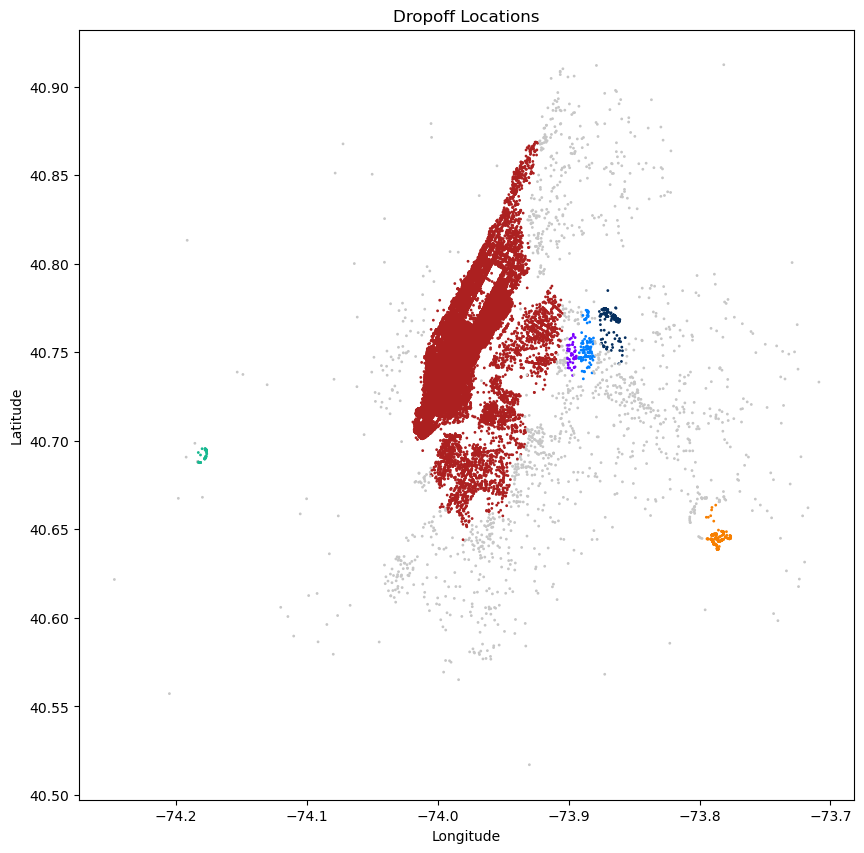

In [950]:
plt.figure(figsize = (10, 10))
# plot dropoff locations and clusters

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title('Dropoff Locations')
plt.scatter(taxi['dropoff_longitude'],
            taxi['dropoff_latitude'], 
            c = taxi['dropoff_clusters_color'], 
            s = 1);
plt.savefig('../images/scatter_dropoff_cluster_locations.png');

In [954]:
dummy_col_dropoffs = pd.get_dummies(taxi['dropoff_clusters'], prefix = 'd', prefix_sep = '_', drop_first = True, dtype = int)

In [956]:
dummy_col_dropoffs.shape

(53351, 6)

In [958]:
print(taxi.shape)
taxi = pd.concat([taxi, dummy_col_dropoffs], axis = 1)
print(taxi.shape)

(53351, 21)
(53351, 27)


In [962]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5'],
      dtype='object')

In [964]:
# update
cols_to_drop.append('dropoff_clusters')
cols_to_drop.append('dropoff_clusters_color')

**Updated Linear Model Part 2**

In [967]:
X3 = taxi.drop(columns = cols_to_drop)
y3 = taxi['fare_amount']

X3.shape, y3.shape

((53351, 12), (53351,))

In [968]:
X3.columns

Index(['geodesic_distance', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5'],
      dtype='object')

In [1408]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state = 1976, stratify = taxi['pickup_clusters'])

In [1410]:
lr3 = LinearRegression()

In [1412]:
lr3.fit(X_train3, y_train3)

LinearRegression()

In [1414]:
round(lr3.score(X_train3, y_train3), 3)

0.836

In [1416]:
round(lr3.score(X_test3, y_test3), 3)

0.837

In [1418]:
y_preds3 = lr3.predict(X_test3)

In [1420]:
round(root_mean_squared_error(y_test3, y_preds3), 3)

3.691

In [1422]:
resids3 = y_test3 - y_preds3

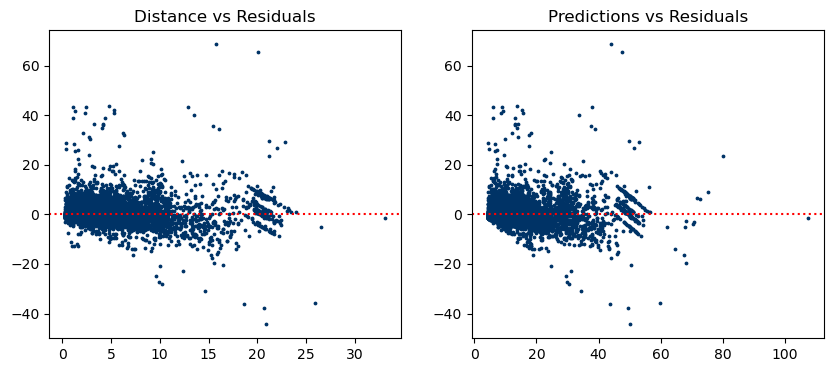

In [1424]:
plt.figure(figsize = (10, 4))
plot1 = plt.subplot(1, 2, 1)
plot2 = plt.subplot(1, 2, 2)

plot1.scatter(X_test3['geodesic_distance'], resids3, s = 3, color = '#003366')
plot1.set_title('Distance vs Residuals')
plot1.axhline(0, color = '#ff0000', linestyle = ':')

plot2.scatter(y_preds3, resids3, s = 3, color = '#003366')
plot2.set_title('Predictions vs Residuals')
plot2.axhline(0, color = '#ff0000', linestyle = ':');

----
#### **Feature Engineering**

---
**Estimated Distance**

Expand, but gist for now: distance is a major driver, but right now dealing with geodesic distances.  At NYC's latitude, and taking the Manhattan grid into account.  Once geo distances exceed 10km the gap between geo and actual increases.  So, in a new column, estimate actual distance by a factor of 1.15 if less than 10km, and by 1.2 if 10km or greater.

In [993]:
taxi['estimated_distance'] = taxi['geodesic_distance'].map(lambda x: x*1.15 if x < 10 else x*1.2)

In [994]:
taxi[taxi['geodesic_distance'] > 9][['geodesic_distance', 'estimated_distance']].head()

,geodesic_distance,estimated_distance
key,,
2009-01-02 19:38:09.000000200,9.460427,10.879491
2009-01-02 21:44:00.000000630,14.917676,17.901212
2009-01-03 04:06:35.000000100,9.649887,11.097370
2009-01-03 21:34:17.000000500,13.954507,16.745408
2009-01-04 00:28:00.000000610,11.871535,14.245842


In [996]:
# check if correlations change significantly
print(round(taxi['geodesic_distance'].corr(taxi['fare_amount']), 5))
print(round(taxi['estimated_distance'].corr(taxi['fare_amount']), 5))

0.90267
0.90256


Although the correlation for estimated distance is negligibly smaller, I'm keeping this one in favor of geodesic because it better approximates reality.

In [999]:
# update
cols_to_drop.append('geodesic_distance')

In [1000]:
X4 = taxi.drop(columns = cols_to_drop)
y4 = taxi['fare_amount']
X4.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance'],
      dtype='object')

In [1460]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, random_state = 1976, stratify = taxi['pickup_clusters'])
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((40013, 12), (13338, 12), (40013,), (13338,))

In [1462]:
lr4 = LinearRegression()
lr4.fit(X_train4, y_train4)

LinearRegression()

In [1464]:
print(round(lr4.score(X_train4, y_train4), 3))
print(round(lr4.score(X_test4, y_test4), 3))

0.835
0.836


In [1466]:
y_preds4 = lr4.predict(X_test4)
round(root_mean_squared_error(y_test3, y_preds4), 3)

3.698

----
**Dollars per Km**

Gist, expand later: In the absence of duration data, the closest proxy would be dollars spend per traveled kilometer.  Now we we have a closer approximation of the actual distance traveled, if we divide the fare by distance we should see differences for trips of the same distance having different fare because one took longer than the other, thus having to pay extra for sitting in traffic, which is one of the fare components.

In [1013]:
# taxi['usd_per_km'] = taxi['fare_amount']/taxi['estimated_distance']
# taxi.columns

In [1014]:
# taxi[['fare_amount','estimated_distance', 'usd_per_km']].head()

In [1015]:
# X = taxi.drop(columns = cols_to_drop)
# X.columns

In [1016]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1976)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [1022]:
# lr5 = LinearRegression()
# lr5.fit(X_train, y_train)

In [1023]:
# print(lr5.score(X_train, y_train))
# print(lr5.score(X_test, y_test))

In [1024]:
# preds = lr5.predict(X_test)
# root_mean_squared_error(y_test, preds)

----
**Interaction: Distance x Hour**

In [1027]:
# if hour is equal to zero, multipy by 1
# else, multiply by hour

taxi['distance_hour'] = taxi.apply(lambda row: row['estimated_distance'] if row['hour'] == 0
                                   else row['estimated_distance'] * row['hour'],
                                   axis = 1)
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5', 'estimated_distance', 'distance_hour'],
      dtype='object')

In [1031]:
taxi[['hour', 'estimated_distance', 'distance_hour']].head()

,hour,estimated_distance,distance_hour
key,,,
2009-01-01 00:48:11.000000200,0,5.196234,5.196234
2009-01-01 00:54:13.000000100,0,5.135030,5.135030
2009-01-01 01:07:13.000000100,1,1.451833,1.451833
2009-01-01 01:12:02.000000100,1,4.061769,4.061769
2009-01-01 04:34:56.000000100,4,1.855340,7.421362


In [1032]:
X5 = taxi.drop(columns = cols_to_drop)
y5 = taxi['fare_amount']
X5.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour'],
      dtype='object')

In [1494]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, random_state = 1976, stratify = taxi['pickup_clusters'])
X_train5.shape, X_test5.shape, y_train5.shape, y_test5.shape

((40013, 13), (13338, 13), (40013,), (13338,))

In [1496]:
lr5 = LinearRegression()
lr5.fit(X_train5, y_train5)

LinearRegression()

In [1498]:
print(round(lr5.score(X_train5, y_train5), 3))
print(round(lr5.score(X_test5, y_test5), 3))

0.836
0.836


In [1500]:
y_preds5 = lr5.predict(X_test5)
round(root_mean_squared_error(y_test5, y_preds5), 3)

3.699

----
**Airport Rides**

Gist, fix later: special fares with airport rides. From JFK to Manhattan is flat rate, from/to LGA there's a surcharge, to EWR there's also a surcharge.

In [1538]:
def is_airport(row):
    if row['pickup_clusters'] == 1 or row['dropoff_clusters'] == 1:
        return 'LGA'
    elif row['pickup_clusters'] == 3 or row['dropoff_clusters'] == 2:
        return 'JFK'
    elif row['dropoff_clusters'] == 3:
        return 'EWR'
    else:
        return None

In [1540]:
# apply to df and create column
taxi['airport_ride'] = taxi.apply(is_airport, axis = 1)

In [1542]:
taxi['airport_ride'].value_counts(dropna = False)

airport_ride
None    50616
LGA      1585
JFK      1089
EWR        61
Name: count, dtype: int64

In [1544]:
# dummify airport_ride
dummy_col_airport = pd.get_dummies(taxi['airport_ride'], drop_first = True, dtype = int)
dummy_col_airport.shape

(53351, 2)

In [1053]:
print(taxi.shape)
taxi = pd.concat([taxi, dummy_col_airport], axis = 1)
print(taxi.shape)

(53351, 30)
(53351, 32)


In [1055]:
taxi.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'minute', 'geodesic_distance',
       'pickup_clusters', 'pickup_clusters_color', 'p_0', 'p_1', 'p_2', 'p_3',
       'p_4', 'dropoff_clusters', 'dropoff_clusters_color', 'd_0', 'd_1',
       'd_2', 'd_3', 'd_4', 'd_5', 'estimated_distance', 'distance_hour',
       'airport_ride', 'JFK', 'LGA'],
      dtype='object')

In [1057]:
# update
cols_to_drop.append('airport_ride')

In [1059]:
X6 = taxi.drop(columns = cols_to_drop)
y6 = taxi['fare_amount']
X6.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA'],
      dtype='object')

In [1576]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, random_state = 1976, stratify = taxi['pickup_clusters'])
X_train6.shape, X_test6.shape, y_train6.shape, y_test6.shape

((40013, 15), (13338, 15), (40013,), (13338,))

In [1578]:
lr6 = LinearRegression()
lr6.fit(X_train6, y_train6)

LinearRegression()

In [1580]:
print(round(lr6.score(X_train6, y_train6), 3))
print(round(lr6.score(X_test6, y_test6), 3))

0.837
0.837


In [1593]:
y_preds6 = lr6.predict(X_test6)
round(root_mean_squared_error(y_test6, y_preds6), 3)

3.683

---
**Peak Rides**

In [1070]:
taxi['peak_rides'] = 0
taxi['peak_rides'].head()

key
2009-01-01 00:48:11.000000200    0
2009-01-01 00:54:13.000000100    0
2009-01-01 01:07:13.000000100    0
2009-01-01 01:12:02.000000100    0
2009-01-01 04:34:56.000000100    0
Name: peak_rides, dtype: int64

In [1072]:
# this crazy logic required chatgpt intervention, what I was creating on my own got too convoluted too quickly
# filter for weekdays (not Saturday or Sunday)
weekday_condition = ~taxi['day_of_week'].isin(['Saturday', 'Sunday'])

# filter for the morning rush hour (6:30 AM to 9:30 AM)
morning_condition = (taxi['hour'] >= 6) & (taxi['hour'] <= 9) & ((taxi['hour'] != 6) | (taxi['minute'] >= 30)) & ((taxi['hour'] != 9) | (taxi['minute'] <= 30))

# filter for the afternoon/evening rush hour (3:00 PM to 8:00 PM)
afternoon_condition = (taxi['hour'] >= 15) & (taxi['hour'] <= 20)

In [1074]:
indexes = taxi[weekday_condition & (morning_condition | afternoon_condition)].index
taxi.loc[indexes, 'peak_rides'] = 1

In [1076]:
taxi['peak_rides'].value_counts()

peak_rides
0    35151
1    18200
Name: count, dtype: int64

In [1078]:
X7 = taxi.drop(columns = cols_to_drop)
y7 = taxi['fare_amount']
X7.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides'],
      dtype='object')

In [1647]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, random_state = 1976, stratify = taxi['peak_rides'])
X_train7.shape, X_test7.shape, y_train7.shape, y_test7.shape

((40013, 16), (13338, 16), (40013,), (13338,))

In [1649]:
lr7 = LinearRegression()
lr7.fit(X_train7, y_train7)

LinearRegression()

In [1651]:
print(round(lr7.score(X_train7, y_train7), 3))
print(round(lr7.score(X_test7, y_test7), 3))

0.835
0.845


In [1653]:
y_preds7 = lr7.predict(X_test7)
round(root_mean_squared_error(y_test7, y_preds7), 3)

3.654

----
**Weekend Rides**

Lore ipsum...

In [1090]:
weekend_condition = taxi['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_condition.value_counts()

day_of_week
False    38290
True     15061
Name: count, dtype: int64

In [1092]:
taxi['weekend_rides'] = 0

In [1094]:
indexes = taxi[weekend_condition].index
taxi.loc[indexes, 'weekend_rides'] = 1

In [1096]:
taxi['weekend_rides'].value_counts()

weekend_rides
0    38290
1    15061
Name: count, dtype: int64

In [1098]:
X8 = taxi.drop(columns = cols_to_drop)
y8 = taxi['fare_amount']
X8.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides'],
      dtype='object')

In [1719]:
X_train8, X_test8, y_train8, y_test8 = train_test_split(X8, y8, random_state = 1976, stratify = taxi['peak_rides'])
X_train8.shape, X_test8.shape, y_train8.shape, y_test8.shape

((40013, 17), (13338, 17), (40013,), (13338,))

In [1721]:
lr8 = LinearRegression()
lr8.fit(X_train8, y_train8)

LinearRegression()

In [1723]:
print(round(lr8.score(X_train8, y_train8), 3))
print(round(lr8.score(X_test8, y_test8), 3))

0.835
0.845


In [1725]:
y_preds8 = lr8.predict(X_test8)
round(root_mean_squared_error(y_test8, y_preds8), 3)

3.652

-----
**Holiday Rides**

In [1727]:
holiday_condition = taxi['month'].isin(['November', 'December'])
holiday_condition.value_counts()

month
False    44628
True      8723
Name: count, dtype: int64

In [1729]:
taxi['holiday_rides'] = 0

In [1731]:
indexes = taxi[holiday_condition].index
taxi.loc[indexes, 'holiday_rides'] = 1

In [1733]:
taxi['holiday_rides'].value_counts()

holiday_rides
0    44628
1     8723
Name: count, dtype: int64

In [1117]:
X9 = taxi.drop(columns = cols_to_drop)
y9 = taxi['fare_amount']
X9.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [1751]:
X_train9, X_test9, y_train9, y_test9 = train_test_split(X9, y9, random_state = 1976, stratify = taxi['peak_rides'])
X_train9.shape, X_test9.shape, y_train9.shape, y_test9.shape

((40013, 18), (13338, 18), (40013,), (13338,))

In [1753]:
lr9 = LinearRegression()
lr9.fit(X_train9, y_train9)

LinearRegression()

In [1755]:
print(round(lr9.score(X_train9, y_train9), 3))
print(round(lr9.score(X_test9, y_test9), 3))

0.835
0.846


In [1757]:
y_preds9 = lr9.predict(X_test9)
round(root_mean_squared_error(y_test9, y_preds9), 3)

3.65

----
#### **Feature Selection**

----
**Lasso**

In [1129]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [1131]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('ls', Lasso(random_state = 1976))             
])

In [1759]:
params = {
    'ls__alpha': [0.001, 0.01, 0.1, 1, 10]
}

In [1761]:
ls_gs = GridSearchCV(pipe,
                  param_grid = params,
                  verbose = 1,
                  n_jobs = -1
                 )

In [1763]:
X_train9.columns

Index(['p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3', 'd_4',
       'd_5', 'estimated_distance', 'distance_hour', 'JFK', 'LGA',
       'peak_rides', 'weekend_rides', 'holiday_rides'],
      dtype='object')

In [1765]:
ls_gs.fit(X_train9, y_train9)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ls', Lasso(random_state=1976))]),
             n_jobs=-1, param_grid={'ls__alpha': [0.001, 0.01, 0.1, 1, 10]},
             verbose=1)

In [1767]:
ls_gs.best_params_

{'ls__alpha': 0.001}

In [1769]:
y_preds9 = ls_gs.predict(X_test9)
round(root_mean_squared_error(y_test9, y_preds9), 3)

3.651

In [1771]:
coefficients = ls_gs.best_estimator_.named_steps['ls'].coef_
coefficients

array([-2.67565055e-01, -5.55937871e-01, -7.96907682e-03, -1.22790428e+00,
        2.62821187e-01, -3.42867878e-01, -4.98172269e-01, -7.14128880e-01,
        9.35130634e-01,  2.48335788e-03, -6.99924704e-02,  7.25654150e+00,
        2.33149113e-01,  1.58381122e+00,  1.46959648e+00,  5.97048168e-02,
       -1.51391654e-01,  1.64123565e-01])

In [1773]:
keys = X_train9.columns
values = [round(i, 2) for i in coefficients]

In [1775]:
coefficients_table = dict(zip(keys, values))
pd.Series(coefficients_table)

p_0                  -0.27
p_1                  -0.56
p_2                  -0.01
p_3                  -1.23
p_4                   0.26
d_0                  -0.34
d_1                  -0.50
d_2                  -0.71
d_3                   0.94
d_4                   0.00
d_5                  -0.07
estimated_distance    7.26
distance_hour         0.23
JFK                   1.58
LGA                   1.47
peak_rides            0.06
weekend_rides        -0.15
holiday_rides         0.16
dtype: float64

In [1777]:
# drop features with very low coefficients (closest to zero)
features_to_keep = list(keys[np.abs(values) >= 0.1])  # <<--- this line of code was result of chatgpt inquiry
print(f'Count: {len(features_to_keep)}')
features_to_keep

Count: 14


['p_0',
 'p_1',
 'p_3',
 'p_4',
 'd_0',
 'd_1',
 'd_2',
 'd_3',
 'estimated_distance',
 'distance_hour',
 'JFK',
 'LGA',
 'weekend_rides',
 'holiday_rides']

In [1169]:
X10 = taxi[features_to_keep]
y10 = taxi['fare_amount']
X10.columns

Index(['p_0', 'p_1', 'p_3', 'p_4', 'd_0', 'd_1', 'd_2', 'd_3',
       'estimated_distance', 'distance_hour', 'JFK', 'LGA', 'weekend_rides',
       'holiday_rides'],
      dtype='object')

In [1847]:
X_train10, X_test10, y_train10, y_test10 = train_test_split(X10, y10, random_state = 1976, stratify = taxi['peak_rides'])
X_train10.shape, X_test10.shape, y_train10.shape, y_test10.shape

((40013, 14), (13338, 14), (40013,), (13338,))

In [1849]:
params2 = {
    'ls__alpha': [0.001, 0.01, 0.1, 1]
}

In [1851]:
ls2_gs = GridSearchCV(pipe,
                  param_grid = params2,
                  verbose = 1,
                  n_jobs = -1
                 )

In [1853]:
ls2_gs.fit(X_train10, y_train10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ls', Lasso(random_state=1976))]),
             n_jobs=-1, param_grid={'ls__alpha': [0.001, 0.01, 0.1, 1]},
             verbose=1)

In [1855]:
ls2_gs.best_params_

{'ls__alpha': 0.001}

In [1857]:
y_preds10 = ls2_gs.predict(X_test10)
round(root_mean_squared_error(y_test10, y_preds10), 3)

3.653

In [1859]:
coefficients2 = ls2_gs.best_estimator_.named_steps['ls'].coef_
coefficients2

array([-0.25405401, -0.54576857, -1.21621796,  0.26566254, -0.3270776 ,
       -0.48664237, -0.7070065 ,  0.93750628,  7.25460361,  0.2376945 ,
        1.5800302 ,  1.46354187, -0.1783943 ,  0.16420398])

In [1861]:
keys2 = X_train10.columns
values2 = [round(i, 2) for i in coefficients2]

In [1863]:
coefficients_table2 = dict(zip(keys2, values2))
pd.Series(coefficients_table2)

p_0                  -0.25
p_1                  -0.55
p_3                  -1.22
p_4                   0.27
d_0                  -0.33
d_1                  -0.49
d_2                  -0.71
d_3                   0.94
estimated_distance    7.25
distance_hour         0.24
JFK                   1.58
LGA                   1.46
weekend_rides        -0.18
holiday_rides         0.16
dtype: float64

RSME is not improving, stuck at 3.65. However, these 14 features seem reasonable given their coefficients. Try the XGBoost regressor as last resort with these features.

----
**XGBooster**

In [1193]:
from xgboost import XGBRegressor

In [1866]:
xgb = XGBRegressor(random_state = 1976)

In [1868]:
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 1.0]
}

In [1870]:
xgb_gs = GridSearchCV(
    xgb,
    param_grid = xgb_params,
    n_jobs = -1,
    verbose = 1
)

In [1872]:
%%time
xgb_gs.fit(X_train10, y_train10)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
CPU times: total: 1min 46s
Wall time: 9min 37s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=1976, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [100, 200, 300, 400],
                         'subsample': [0.6, 0.7, 0.8, 1.0]},
             verbose=1)

In [1874]:
xgb_gs.best_score_

0.8365857623726148

In [1876]:
y_preds11 = xgb_gs.predict(X_test10)
round(root_mean_squared_error(y_test10, y_preds11), 3)

3.602

XGBooster yielded a 1.4% improvement in RMSE.

-------

In [1890]:
taxi.shape

(53351, 35)

In [1879]:
taxi.to_csv('../data/clean_data/taxi_clean_set_v3.csv')

In [1880]:
import pickle

In [1883]:
with open('../models/xgb_model.pkl', 'wb') as x:
  pickle.dump(xgb_gs, x)

In [1885]:
with open('../models/dbs_pickups.pkl', 'wb') as p:
  pickle.dump(dbs1, p)

In [1887]:
with open('../models/dbs_dropoffs.pkl', 'wb') as d:
  pickle.dump(dbs2, d)